# Exploring the vertex transforms used in OpenGL
## Model, view and projection matrices
How does your software (e.g., video game) go from a model of a 3d world to what you see on the screen? One important aspect of this rendering pipeline is the sete of geometrical transformations known as the model transform, view transform, and projection matrix. I won't explain them here, but this code is meant to help sharpen your intuitions by working through a very simple example without needing any OpenGL but just simple matplotlib.

For really good overviews of these topics, see:
- [Computing 2d coordinates of 3d points](http://www.scratchapixel.com/lessons/3d-basic-rendering/computing-pixel-coordinates-of-3d-point/mathematics-computing-2d-coordinates-of-3d-points)
- [OpenGL Coordinate System Transforms](https://learnopengl.com/Getting-started/Coordinate-Systems)

In [1]:
import numpy as np
import matplotlib.pyplot as plt #plt.plot(x, y)
import matplotlib as mpl
from mpl_toolkits.mplot3d.art3d import Poly3DCollection #, Line3DCollection
plt.style.use('classic')

### First create the 3d graphical object and helper functions
The main class here is `GraphObject3D`: it contains all the vertices (called `points`), and methods for doing the standard transforms (scale, translate, rotate), plotting the object, and its projection to the x-y plane. 

In [2]:

class GraphObject3D:
    """ 
    Generic 3d graphical object to be used for plotting and applying
    TRS operations (translate, rotate, scale). Created to illustrated model and
    view transforms in OpenGL context.
    """
    def __init__(self, points, face_inds, position=np.array([0, 0, 0])):
        self.points = points;
        self.face_inds = face_inds
        #Object starts at position 0, and is translated to given position
        self.initial_position = position
        self.translate(position)
           
    def scale(self, scale_factor):
        scale_mat = np.array([[scale_factor, 0,            0,              0],
                              [0,            scale_factor, 0,              0],
                              [0,            0,            scale_factor,   0],
                              [0,            0,            0,              1]]);
        self.points = scale_mat.dot(self.points)
        
    def translate(self, translate_value):
        translation_mat = np.array([[1,  0,  0, translate_value[0]],
                                    [0,  1,  0, translate_value[1]],
                                    [0,  0,  1, translate_value[2]],
                                    [0,  0,  0,                 1]]);
        self.points = translation_mat.dot(self.points)
        
    def xrotate(self, theta):
        xrotation_mat = np.array([
                          [   1,     0,              0,         0,],
                          [   0, np.cos(theta),  -np.sin(theta), 0,],
                          [   0, np.sin(theta),  np.cos(theta), 0,],
                          [   0,      0,              0,        1,]
                        ])
        self.points = xrotation_mat.dot(self.points)
        
    def yrotate(self, theta):
        yrotation_mat = np.array([
                          [   np.cos(theta),    0,  np.sin(theta),  0,],
                          [   0,                1,    0,            0,],
                          [  -np.sin(theta),    0,  np.cos(theta),  0,],
                         [   0,                0,        0,        1,]
                        ])
        self.points = yrotation_mat.dot(self.points)  
        
    def zrotate(self, theta):
        zrotation_mat = np.array([
                          [ np.cos(theta),  -np.sin(theta), 0, 0,],
                          [ np.sin(theta),   np.cos(theta), 0, 0,],
                          [   0,      0,              1,        0,],
                          [   0,      0,              0,        1,],                       
                        ])
        self.points = zrotation_mat.dot(self.points) 
                                       
    def transform(self, transform_matrix):
        """
        If you want to feed in your own arbitrary transform, go ahead.
        """
        self.points = transform_matrix.dot(self.points)
        
    @property
    def xcart(self):
        return self.points[0,:]/self.w
        
    @property
    def ycart(self):
        return self.points[1,:]/self.w
    
    @property
    def zcart(self):
        return self.points[2,:]/self.w
    
    @property
    def w(self):
        return self.points[3,:]
   
    @property 
    def faces(self):
        """
        This assumes w=1 and breaks otherwise. To do: fix by dividing by w
        """
        num_faces = self.face_inds.shape[0]
        faces = []
        for face_num in range(num_faces):
            faces.append([np.array(self.points[0:3, i]/self.w[i]) for i in self.face_inds[face_num]])
        return np.array(faces)
        
        
    def plot(self, axes = None, edgecolor = 'b', facecolor = 'cyan'):
        """
        Plots the object in 3d space
        """
        if axes == None:
            fig = plt.figure()
            axes = fig.add_subplot(111, projection='3d')
        #Plot vertices
        axes.scatter3D(self.xcart, self.ycart, self.zcart, color = edgecolor)
        #Plot edges and faces
        collection = Poly3DCollection(self.faces, linewidths = 1, alpha = 0.25)
        collection.set_facecolor(facecolor)
        collection.set_edgecolor(edgecolor)
        axes.add_collection3d(collection)
        axes.set_aspect('equal')
        set_axes_equal(axes)  #from stack overflow
        return axes
    
    def plot_projection(self, axes = None, color = 'b'):
        """
        Plots the projection to the image plane (xy plane), and draws
        the device-normalized coordinate frame for reference (square 
        from -1 to 1).
        """
        if axes == None:
            fig, axes = plt.subplots()
        axes.scatter(self.xcart, self.ycart, color = color)
        #plot x-y projection of each face in 2d
        for face in self.faces:
            xvals = [arr[0] for arr in face]
            xvals.append(xvals[0])
            yvals = [arr[1] for arr in face]      
            yvals.append(yvals[0])
            axes.plot(xvals, yvals, color = color)
            
        viewport = np.array([[1, -1, -1, 1, 1],
                             [1, 1, -1, -1, 1]]) 
        axes.plot(viewport[0,:], viewport[1,:], color = 'k')
        axes.set_xlabel('x')
        axes.set_ylabel('y')
        axes.grid(color = (.8, .8, .8), linestyle = 'solid')
        axes.axis('tight')
        axes.set_aspect('equal')
        return axes
    

def centroid(points):
    """ For when you want to plot the center of an object """
    x_center = np.mean(points[0,:])
    y_center = np.mean(points[1,:])
    z_center = np.mean(points[2,:])
    return np.array([x_center, y_center, z_center])


def set_axes_radius(ax, origin, radius):
    '''
    Helper function for set_axes_equal.
    From https://stackoverflow.com/a/50664367/1886357
    '''
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    This is from:
      https://stackoverflow.com/a/50664367/1886357
      
    Usage:
         ax.set_aspect('equal')
         set_axes_equal(ax)
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)

### Populate the world with a couple of objects
#### Create a camera object  

In [27]:
camera_target = np.array([1/np.sqrt(2), 1, 1/np.sqrt(2),])
xvals = [-camera_target[0]/2, camera_target[0]]
yvals = [-camera_target[1]/2, camera_target[1]]
zvals = [-camera_target[2]/2, camera_target[2]]


cam_width = 1;
cam_height = cam_width/np.sqrt(2);
cam_coord = cam_width/2;
cam_points = np.array([
        [-cam_coord,  cam_coord,   cam_coord, -cam_coord,    0,],      
        [ cam_coord,  cam_coord,  -cam_coord, -cam_coord,    0,],
        [ cam_height, cam_height,  cam_height, cam_height,  0],
        [ 1.,  1,  1,  1, 1,] ]);
    
# generate list of sides' polygons of our camera (four sides then base)
cam_face_inds = np.array([
        [0, 1, 4],
        [0, 3, 4],
        [2, 1, 4],
        [2, 3, 4],
        [0, 1, 2, 3]]);
#Create camera instance
camera = GraphObject3D(cam_points, cam_face_inds)

#### Rotate the camera and place it in the world 
This is what the model matrix does. Here we are rotating it, translating it. We could create a single matrix by multiplying the rotation and translation transforms together, and that would be the world matrix. This way of doing it separately is equivalent but useful when you want to tinker with the way the camera is embedded in the world.

In [4]:
#orient camera
camera.xrotate(-np.pi/4)
camera.yrotate(np.pi/4)

# put camera in world
cam_initial_position = -1.5*np.array(camera_target);
camera.translate(cam_initial_position);

#### Plot the camera
Just for fun, to check it out. 

In [7]:
%matplotlib notebook  #so plots are interactive

<IPython.core.display.Javascript object>


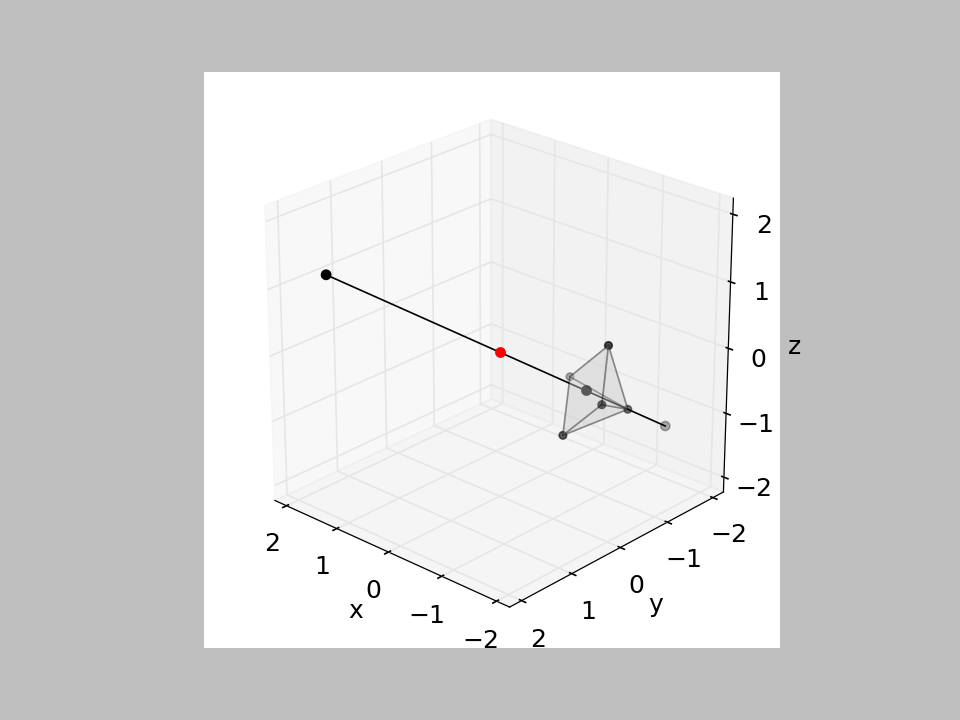

In [16]:
ax_world = camera.plot(facecolor = (.8, .8, .8), edgecolor = 'k')
scale_factor = 1.3;
scatter_size = 30
#Plot the line along which the camera points
xvals_new = scale_factor*np.array([cam_initial_position[0], -cam_initial_position[0]])
yvals_new = scale_factor*np.array([cam_initial_position[1], -cam_initial_position[1]])
zvals_new = scale_factor*np.array([cam_initial_position[2], -cam_initial_position[2]])
ax_world.plot(xvals_new, yvals_new, zvals_new, color = 'k', linewidth = 1)
ax_world.scatter3D(xvals_new, yvals_new, zvals_new, s = scatter_size, color = 'k')
#plot centroid
cam_shifted_centroid = centroid(camera.points[0:3, 0:4])
ax_world.scatter3D(cam_shifted_centroid[0], cam_shifted_centroid[1], cam_shifted_centroid[2], 
                   s = scatter_size, color = 'k')
ax_world.scatter3D(0, 0, 0, s = scatter_size, color = 'r')

ax_world.set_xlabel('x')
ax_world.set_ylabel('y')
ax_world.set_zlabel('z')
ax_world.axis('tight')
ax_world.set_aspect('equal')
set_axes_equal(ax_world) 

#### Create generic cube to populate the world

In [9]:
# Set up generic cube
cube_points = np.array([
                [-1,  1,  1, -1, -1,  1, 1, -1,],
                [-1, -1,  1,  1, -1, -1, 1,  1,],
                [-1, -1, -1, -1,  1,  1, 1,  1, ], 
                 [1,  1,  1,  1,  1,  1, 1,  1, ]]);

cube_face_inds = np.array([
        [0, 1, 2, 3,],
        [4, 5, 6, 7,],
        [0, 1, 5, 4,],
        [2, 3, 7, 6,],
        [1, 2, 6, 5,],
        [4, 7, 3, 0]
        ])    

#### Create cube 1, rotate it, and place it in world
Again, this is basically taking care of the operations of the model matrix.

In [10]:
cube1_initial_position = -1.5*cam_initial_position
cube1 = GraphObject3D(cube_points, cube_face_inds)
cube1.scale(.8)
cube1.xrotate(np.pi/6)
cube1.yrotate(np.pi/4)
cube1.translate(cube1_initial_position)

#### Do same for a second cube
This little one we are putting outside the view of the camera.

In [11]:
cube2_initial_position = -2*cam_initial_position
cube2 = GraphObject3D(cube_points, cube_face_inds)
cube2.scale(.5)
cube2.xrotate(np.pi/6)
cube2.yrotate(np.pi/4)
cube2.translate(cube2_initial_position)
cube2.zrotate(-np.pi/1.5)

#### Plot the cubes in the same axes as the camera

<IPython.core.display.Javascript object>


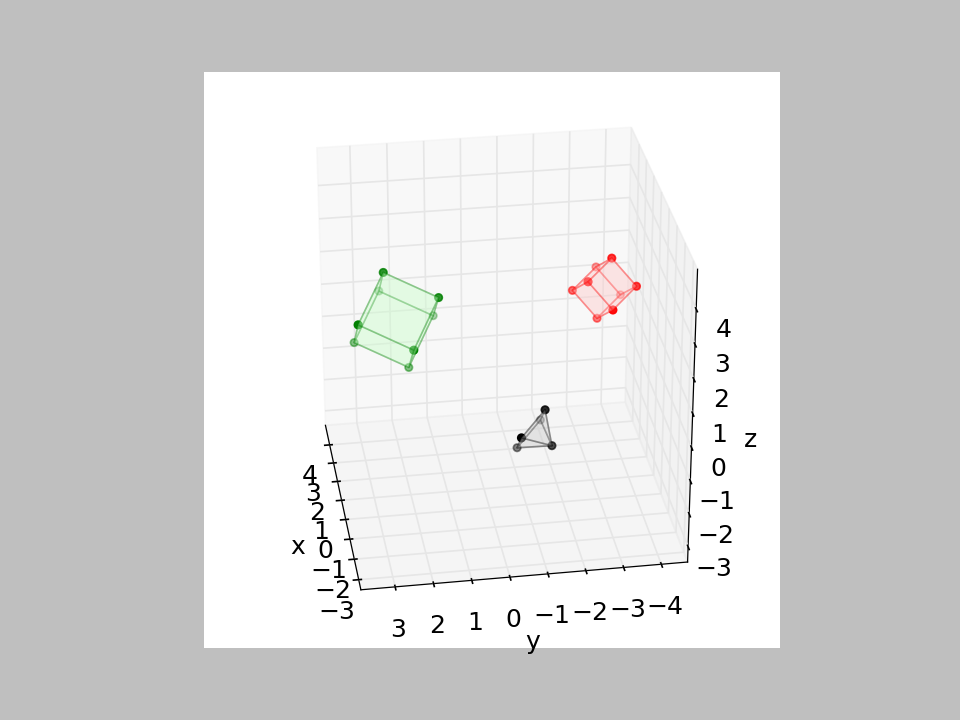

In [15]:
ax_world = camera.plot(facecolor = (.8, .8, .8), edgecolor = 'k')
cube1.plot(axes = ax_world, facecolor = (.8, 1, 0.8), edgecolor = 'g')
cube2.plot(axes = ax_world, facecolor = (1.0, 0.8, 0.8), edgecolor = 'r')
ax_world.set_xlabel('x')
ax_world.set_ylabel('y')
ax_world.set_zlabel('z')
ax_world.axis('tight')
ax_world.set_aspect('equal')
set_axes_equal(ax_world) 

### Apply the view matrix
You've got a world, and there is a camera in it, but you want to determine how 
it will *look* to the camera. First, transform everything in the world to a 
camera-based coordinate system. This involves first translating with Vt so that 
the camera is at the origin. Then rotating the world so that it aligns with the 
*camera's* main axes.         

There are some good discussions of this online. For instance:
- [World, view, and projection transformation matrix](http://www.codinglabs.net/article_world_view_projection_matrix.aspx) (Conceptual)
- [Constructing the viewing matrix](http://www.songho.ca/opengl/gl_camera.html#lookat) (Mathematical)

#### Translate with Vt 
First shift the world so that the camera is at zero.

In [18]:
trans_mag = -cam_initial_position;
Vt = np.array([
        [1, 0, 0, trans_mag[0],],
        [0, 1, 0, trans_mag[1],],
        [0, 0, 1, trans_mag[2],],
        [0, 0, 0, 1]]);
camera.transform(Vt)
cube1.transform(Vt)
cube2.transform(Vt)

#### Rotate with Vr
While the camera is at the origin now (you can plot it if you want with camera.plot(), 
the world needs to be rotated so its contents are represented relative to the camera.
The rotation to align the world with the camera's axes is taken care of by Vr.

Mathematically, this is a change of basis from the world- to camera-based coordinate system.
One reason for contructing these orthonormal basis sets is because when you put them in a
matrix, the inverse can be calculated simply by taking the transpose.

In [19]:
target = -camera_target/np.linalg.norm(camera_target); #p-e/norm(p-e) p is zero
up_raw = np.array([-np.sqrt(2), 0., np.sqrt(2)])
up = up_raw/np.linalg.norm(up_raw)
side_raw = np.cross(up, target)  #-forward b/c convention is forward is from object to camera
side = side_raw/np.linalg.norm(side_raw)
# Construct Vr and apply
Vr = np.array([
                [side[0],     side[1],  side[2],  0,],
                [up[0],          up[1],   up[2],  0,],
                [target[0], target[1], target[2], 0],
                [0, 0, 0, 1,]
              ])
camera.transform(Vr)
cube1.transform(Vr)
cube2.transform(Vr)

#### Plot the world in the new coordinate system
The world is now in a right-handed coordinate system centered on the camera that is facing in the-z direction. Let's take a look.

<IPython.core.display.Javascript object>


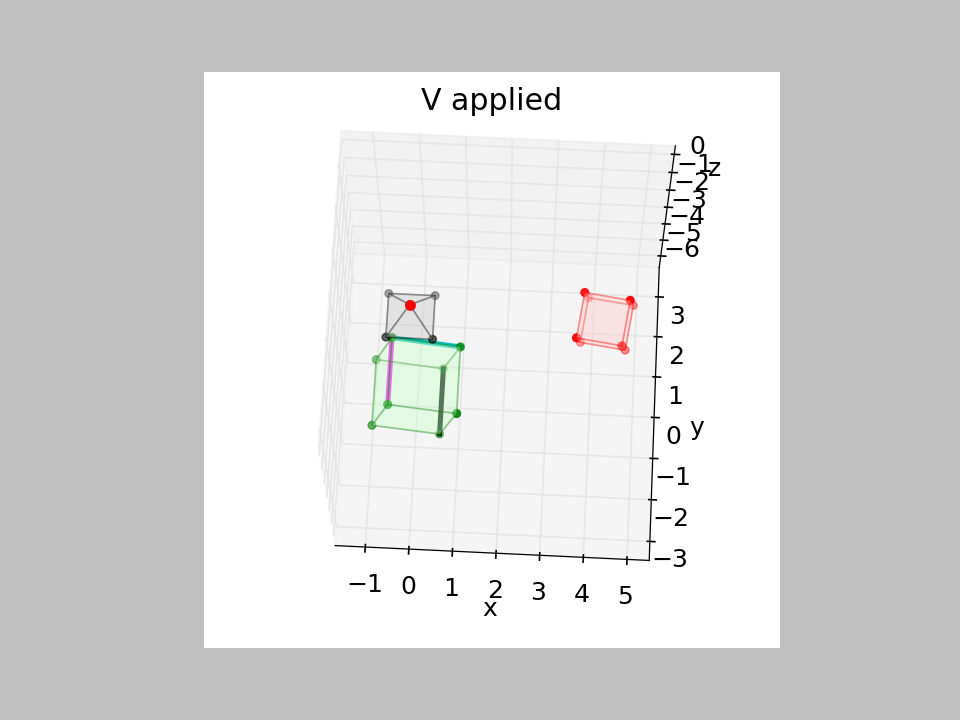

In [21]:
scatter_size = 30;
cam_centroid = centroid(camera.points[0:3, 0:4])

ax3 = camera.plot(edgecolor = 'k', facecolor = (.8, .8, .8))
cube1.plot(axes = ax3, edgecolor = 'g', facecolor = (.8, 1, .8))
cube2.plot(axes = ax3, edgecolor = 'r', facecolor = (1, .8, .8))      
ax3.scatter3D(0, 0, 0, s = scatter_size, color = 'r')
#Plot three benchmark edges that we will use to look at projections later
lf_inds = [0, 1]  #left front
rb_inds = [6, 7]  #right back
tf_inds = [0, 4] #top front
ax3.plot([cube1.xcart[lf_inds[0]], cube1.xcart[lf_inds[1]]],
         [cube1.ycart[lf_inds[0]], cube1.ycart[lf_inds[1]]],
         [cube1.zcart[lf_inds[0]], cube1.zcart[lf_inds[1]]], color = (1, 0, 1), linewidth = 3)
ax3.plot([cube1.xcart[rb_inds[0]], cube1.xcart[rb_inds[1]]],
         [cube1.ycart[rb_inds[0]], cube1.ycart[rb_inds[1]]],
         [cube1.zcart[rb_inds[0]], cube1.zcart[rb_inds[1]]], color = 'k', linewidth = 3)
ax3.plot([cube1.xcart[tf_inds[0]], cube1.xcart[tf_inds[1]]],
         [cube1.ycart[tf_inds[0]], cube1.ycart[tf_inds[1]]],
         [cube1.zcart[tf_inds[0]], cube1.zcart[tf_inds[1]]], color = 'c', linewidth = 3)
plt.title('V applied')  
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.axis('tight')
ax3.set_aspect('equal')
set_axes_equal(ax3)  

### On to the projection matrix
Now that the camera is at the origin and facing -z, it is time to determine what
image is projected to the camera's image plane. There are many derivations of the formula
for the projection matrix, and some of them are different: the main thing is make sure your
values satisfy certain constraints (see below). I recommend this derivation:
[Projection Matrix](http://www.songho.ca/opengl/gl_projectionmatrix.html#perspective)
 

#### Create the projection matrix and apply it to cube1

In [23]:
proj_mat = np.zeros((4,4));
fov_angle = np.pi/3; 
angle_tan = np.tan(fov_angle/2);  
width = 4;
height = 3;
aspect_ratio = width/height;
far_z = 10;
near_z = 1;

proj_mat[0, 0] = 1/(angle_tan*aspect_ratio);
proj_mat[1,1] = 1/angle_tan;
proj_mat[2,2] = (near_z+far_z)/(near_z - far_z)
proj_mat[2,3] = (2*near_z*far_z)/(near_z - far_z)
proj_mat[3,2] = -1;

cube1.transform(proj_mat)

#### Plot how the vectors pointing along the (negative) z axis will behave vs z
When `z=-near_z`, it should project to -1, and at `z=-far_z`, it should project to +1. This is a great
way to troubleshoot your code.

<IPython.core.display.Javascript object>


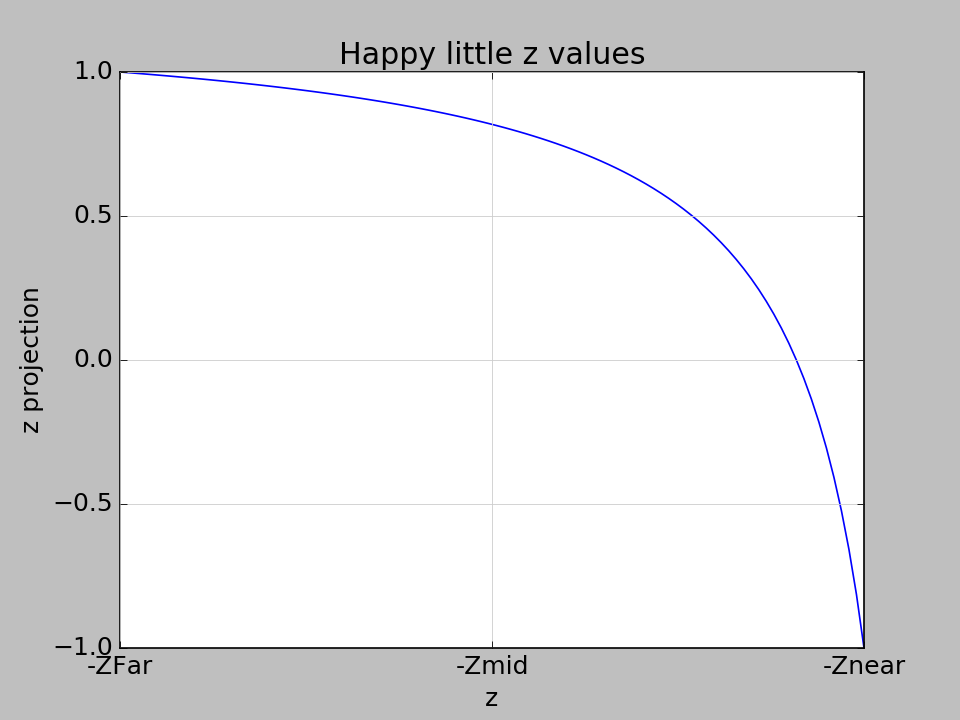

Text(0.5, 1.0, 'Happy little z values')

In [25]:
zvals = np.linspace(-near_z, -far_z, num = 100)
proj_values = []
for z in zvals:
    full_projection = proj_mat.dot(np.array([0,0,z,1]))
    zprojection = full_projection[2]/full_projection[3]
    proj_values.append(zprojection)
fig, axz = plt.subplots()
axz.plot(zvals, proj_values)
axz.set_xlabel('z')
axz.set_ylabel('z projection')
axz.set_xticks([-far_z, -far_z+(far_z - near_z)/2, -near_z])
axz.set_xticklabels(['-ZFar', '-Zmid', '-Znear'])
axz.grid(color = (.8, .8, .8), linestyle = 'solid')
axz.axis('tight')
axz.set_title('Happy little z values')

#### Projection of the green cube onto the x-y plane.
Anything outside of the `[-1, 1]` square is outside of the camera's NDC (normalized device coordinates) and will not be rendered. (But what about on the z axis? The same thing holds. See previous graph: if something doesn't fall within
`[-z_near, -z_far]`, it will not be rendered.

<IPython.core.display.Javascript object>


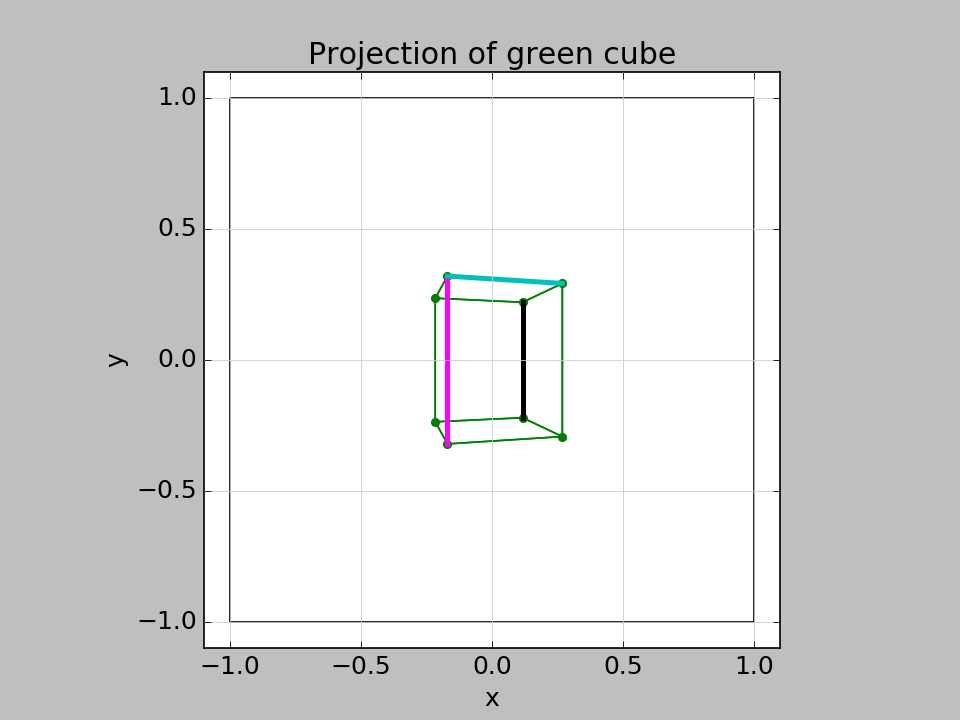

Text(0.5, 1.0, 'Projection of green cube')

In [24]:
ax = cube1.plot_projection(color = 'g') 
ax.plot([cube1.xcart[lf_inds[0]], cube1.xcart[lf_inds[1]]],
         [cube1.ycart[lf_inds[0]], cube1.ycart[lf_inds[1]]], color = (1, 0, 1), linewidth = 3)
ax.plot([cube1.xcart[rb_inds[0]], cube1.xcart[rb_inds[1]]],
         [cube1.ycart[rb_inds[0]], cube1.ycart[rb_inds[1]]], color = 'k', linewidth = 3)
ax.plot([cube1.xcart[tf_inds[0]], cube1.xcart[tf_inds[1]]],
         [cube1.ycart[tf_inds[0]], cube1.ycart[tf_inds[1]]], color = 'c', linewidth = 3)
ax.set_title('Projection of green cube')

#### Look at cube in 3d after application of projection matrix
Note that it falls within the NDC in z.

<IPython.core.display.Javascript object>


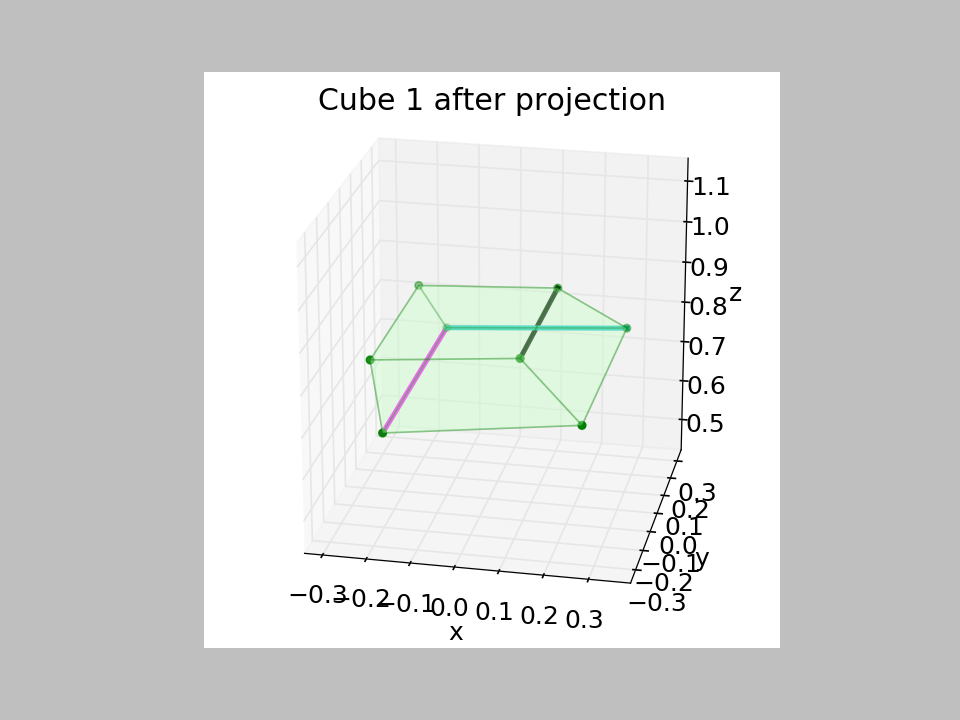

In [26]:
axp1 = cube1.plot(facecolor = (.8, 1, .8), edgecolor = 'g')
axp1.set_title("Cube 1 after projection")
axp1.plot([cube1.xcart[lf_inds[0]], cube1.xcart[lf_inds[1]]],
         [cube1.ycart[lf_inds[0]], cube1.ycart[lf_inds[1]]],
         [cube1.zcart[lf_inds[0]], cube1.zcart[lf_inds[1]]], color = (1, 0, 1), linewidth = 3)
axp1.plot([cube1.xcart[rb_inds[0]], cube1.xcart[rb_inds[1]]],
         [cube1.ycart[rb_inds[0]], cube1.ycart[rb_inds[1]]],
         [cube1.zcart[rb_inds[0]], cube1.zcart[rb_inds[1]]], color = 'k', linewidth = 3)
axp1.plot([cube1.xcart[tf_inds[0]], cube1.xcart[tf_inds[1]]],
         [cube1.ycart[tf_inds[0]], cube1.ycart[tf_inds[1]]],
         [cube1.zcart[tf_inds[0]], cube1.zcart[tf_inds[1]]], color = 'c', linewidth = 3)
axp1.set_xlabel('x')
axp1.set_ylabel('y')
axp1.set_zlabel('z')
axp1.axis('tight')
axp1.set_aspect('equal')
set_axes_equal(axp1)  

## That's it!
We have moved our objects to the correct locations int he world (model matrix), transformed the world into a camera-based coordinate system (view matrix), and then used a perspectival projection matrix to show what this world would look like in normalized device coordinates. Note this is not meant to be an explanation of these steps, but a simple little toy model that *illustrates* the steps. For explanation, I recommend the sites I linked at the beginning. Enjoy!